In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
!pip install yfinance
import yfinance as yf

     |████████████████████████████████| 6.3 MB 7.4 MB/s 
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [ ]:
%cd '/content/gdrive/MyDrive/GWP2M8'

/content/gdrive/MyDrive/GWP2M8


# Q.1

In [ ]:
# Parameters
outside_before = '2020-01-01'
outside_after = '2021-12-01'
spdr_list = ['XLF', 'XLU', 'XLRE', 'XLE', 'XLB', 'XLI', 'XLK', 'XTL', 'XLP','XLY', 'XLV']
spdr_file = "GWP1SPDR.xlsx"
factor_file = "GWP1Factors.xlsx"

In [ ]:
def assemble_factors(factors):
  factor_data = pd.DataFrame()
  for row in factors.iterrows():
    seriecode = row[1]['SeriesCode']
    factor = pd.read_excel(factor_file,sheet_name=seriecode, skiprows=10)
    factor.set_index(keys = 'observation_date', drop=False, inplace=True)
    factor.drop(labels='observation_date', axis=1, inplace=True)
    factor_data = factor_data.join(factor, how='outer')
    factor_data.fillna(inplace=True, method='ffill')
    factor_data.reset_index(inplace=True)
    factor_data = factor_data[ (factor_data['observation_date'] > outside_before) &
    (factor_data['observation_date'] < outside_after)]
    factor_data.set_index(keys = 'observation_date', drop=True, inplace=True)
    factor_data = factor_data.resample('MS').first()
  return factor_data

In [ ]:
spdrs = pd.DataFrame()
for key in spdr_list:
  dat = pd.read_excel(spdr_file, sheet_name=key)
  dat.set_index('observation_date', inplace=True)
  spdrs = spdrs.join(dat, how='outer')
  
spdrs.fillna(inplace=True, method='ffill')
spdrs = spdrs.resample('MS').first()
spdrs.head()

,XLF,XLU,XLRE,XLE,XLB,XLI,XLK,XTL,XLP,XLY,XLV
observation_date,,,,,,,,,,,
2013-12-01,17.7507,37.97,NaN,88.51,46.22,52.26,35.74,55.3300,42.98,66.83,55.440
2014-01-01,17.6532,37.39,NaN,87.25,45.85,51.53,35.39,54.9900,42.45,66.52,55.130
2014-02-01,16.6707,38.79,NaN,81.89,43.01,48.64,34.09,53.8300,39.88,61.17,54.860
2014-03-01,17.4827,40.05,NaN,87.09,46.97,51.71,35.96,56.0032,42.12,66.21,59.000
2014-04-01,18.1729,41.17,NaN,89.59,47.54,52.70,36.78,57.8757,42.99,65.62,58.855


In [ ]:
factors = pd.read_excel(factor_file, sheet_name="Weights")
overall_factors = assemble_factors(factors)

lei = factors[factors.TypeCode=='LEI']
lei_factors = assemble_factors(lei)
lei_weights = lei.set_index('Index data')['Weight']

cei = factors[factors.TypeCode=='CEI']
cei_factors = assemble_factors(cei)
cei_weights = cei.set_index('Index data')['Weight']

lag = factors[factors.TypeCode=='LAG']
lag_factors = assemble_factors(lag)
lag_weights = lag.set_index('Index data')['Weight']

overall_factors.head()

,AWHMAN,IC4WSA,ACDGNO,ISM-NewOrders,NEWORDER,PERMIT,SP500,NFCINONFINLEVERAGE,T10YFF,UMCSENT,PAYEMS,W875RX1,INDPRO,CMRMTSPL,MNFCTRIRSA,UEMPMEAN,TDSP,TOTCI,DPRIME,ULCMFG,CUSR0000SASLE
observation_date,,,,,,,,,,,,,,,,,,,,,
2020-02-01,41.7,210000.0,38205.0,49.8,64885.0,1478.0,3225.52,-0.71996,-0.08,101.0,152523.0,14225.6,101.3247,1491663.0,1.51,20.8,9.789757,2351.0927,4.75,124.250,343.671
2020-03-01,41.3,214000.0,30301.0,42.2,64103.0,1382.0,2954.22,-0.70688,-0.45,89.1,150840.0,13872.2,97.4477,1432305.0,1.58,16.7,9.789757,2352.9421,4.75,124.250,343.850
2020-04-01,38.5,2344000.0,13709.0,27.1,59872.0,1094.0,2470.50,-0.73743,0.56,71.8,130161.0,13088.0,84.2018,1267304.0,1.83,6.1,8.808557,2797.0623,3.25,135.613,342.854
2020-05-01,39.4,4667750.0,17478.0,31.8,61297.0,1246.0,2830.71,-0.88560,0.59,72.3,132994.0,13325.5,85.8434,1368553.0,1.79,10.4,8.808557,3014.4546,3.25,135.613,342.733
2020-06-01,39.9,1989000.0,34092.0,56.4,64300.0,1296.0,3055.73,-1.11464,0.61,78.1,137840.0,13543.8,91.1622,1473373.0,1.63,15.5,8.808557,3018.7173,3.25,135.613,343.733


# Q.2

In [ ]:
spdrs_std = spdrs.std()


In [ ]:
# std deviation of securities
spdrs_std.head()

XLF      4.176515
XLU      6.582605
XLRE     2.654294
XLE     10.492681
XLB      5.575299
dtype: float64

In [ ]:
# correlation
correlation = spdrs['XLU'].corr(spdrs['XLE'])
correlation

-0.647045210690848

In [ ]:
# portfolio standarad deviation 
spdrs.std().mean()

8.841816984863888

In [ ]:
spdrs_rets = spdrs.pct_change()
spdrs_rets=spdrs_rets.dropna().reset_index()

In [ ]:
# Weighted returns
weighted_returns=sum((spdrs_rets['XLU'] + spdrs_rets['XLE'])/2)
weighted_returns

0.25552356206110854

In [ ]:
pf_data=spdrs[['XLU','XLE']]

In [ ]:
log_returns = np.log(pf_data/pf_data.shift(1))
log_returns

,XLU,XLE
observation_date,,
2013-12-01,NaN,NaN
2014-01-01,-0.015393,-0.014338
2014-02-01,0.036759,-0.063401
2014-03-01,0.031966,0.061565
2014-04-01,0.027581,0.028302
...,...,...
2019-09-01,0.057020,-0.068900
2019-10-01,0.014032,0.010954
2019-11-01,-0.007771,0.024764


In [ ]:
# log returns
log_returns.cov()

,XLU,XLE
XLU,0.001442,0.000116
XLE,0.000116,0.003248


# Q.3

In [ ]:
portfolio_returns = []
portfolio_volatilities = []
assets = ['XLU', 'XLE']

for x in range(1000):
    weights = np.random.random(len(assets))
    weights /= np.sum(weights)
    
    portfolio_returns.append(np.sum(weights * log_returns.mean()) * 250)
    portfolio_volatilities.append(np.sqrt(np.dot(weights.T,                                    np.dot(log_returns.cov() * 250, weights))))
                    
portfolio_returns = np.array(portfolio_returns)
portfolio_volatilities = np.array(portfolio_volatilities)
                                  
portfolio_returns, portfolio_volatilities

(array([ 4.33967946e-01,  9.58386020e-01, -8.29705758e-02,  3.62555173e-01,
         7.44947951e-02, -6.03175345e-01,  8.25753642e-01, -4.58928613e-01,
        -7.87084151e-01,  8.88126758e-01, -1.17964309e+00,  1.15133569e+00,
        -4.23812497e-01,  7.87442812e-01,  4.46430630e-01,  1.55616646e+00,
         8.60110648e-01,  9.92085818e-01, -4.56321499e-01,  6.55483432e-01,
        -1.16311054e+00, -3.88848928e-01,  8.84354268e-01,  8.47493385e-01,
         2.05639547e-01, -6.35760864e-01,  1.70042424e-04, -7.34255104e-01,
         1.76459807e+00, -6.24967872e-02,  1.27825265e+00, -4.24150934e-01,
        -5.06881711e-01, -4.43168715e-01,  4.40701579e-01, -2.08710226e-01,
         2.66385921e-01, -4.08840005e-02,  1.31109141e+00, -7.33984516e-01,
        -4.30528162e-01, -4.76121212e-01, -7.78823852e-02, -1.30358994e-02,
         1.32731614e-01, -3.28259190e-01, -3.16192723e-01,  1.31185239e+00,
         3.12200839e-01, -2.27250249e-01,  1.53116010e+00, -1.89724138e-01,
         4.6

In [ ]:
#expected portfolio return
np.sum(weights * log_returns.mean()) * 250

0.429137147839335

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


Text(0, 0.5, 'Expected Return')

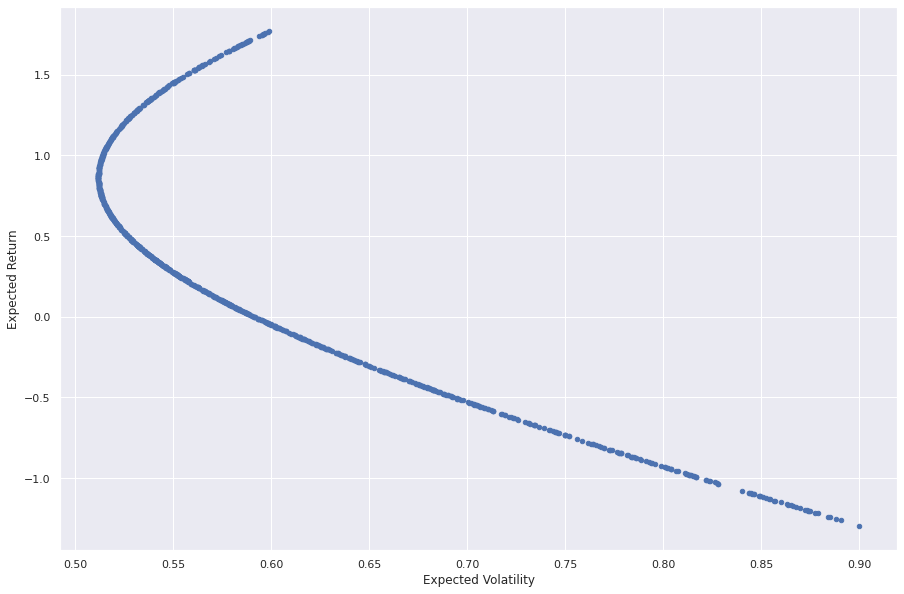

In [ ]:
portfolios = pd.DataFrame({'Return': portfolio_returns, 'Volatility':portfolio_volatilities  })
portfolios.plot(x='Volatility', y='Return', kind='scatter', figsize=(15,10));
plt.xlabel('Expected Volatility')
plt.ylabel('Expected Return')